In [104]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.ornstein_uhlenbeck import OrnsteinUhlenbeck

import numpy as np
from scipy.special import comb

%matplotlib inline

- $p(t,T)$: Forward-Price zum Zeitpunkt $t$ mit Expiry $T$
- $f_i(t,T)$: Forecast der i-ten Technology für $T$ zum Zeitpunkt $t$
    - Annahme: Forecast stueckweise Konstant in der Zeit (Sprung an Forecast Terminen)
- $c(t,T)$ stochastische Groesse, die unabhaengig vom Forecast den Strompreis beeinflusst

In [204]:
def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
    result *= x ** (N + 1)
    return result

def _logit(x):
    return np.log(x/(1-x))

def _inv_logit(x):
    return 1.0/(1+np.exp(-x))


class WindPowerForecastModel:
    
    def _eval_grid(f, timegrid):
        try:
            return f(timegrid)
        except:
            result = np.full(timegrid.shape, f)
            return result

    def __init__(self, speed_of_mean_reversion: float, 
                     volatility: float,
                    expiries: List[float],
                    forecasts: List[float], # must be given as logit of percentage of max_capacity
                    name:str = 'Wind_Germany'):
        self.ou = OrnsteinUhlenbeck(speed_of_mean_reversion, volatility, mean_reversion_level=0.0)
        self.expiries = expiries
        self.forecasts = forecasts
        self.name = name
        self._timegrid = None
        
        self._ou_additive_forward_corrections = np.empty((len(expiries)))
        for i in range(len(expiries)):
            mean_ou = _inv_logit(ou.compute_expected_value(0.0, expiries[i]))
            correction = _logit(forecasts[i])-ou.compute_expected_value(0.0, expiries[i])
            self._ou_additive_forward_corrections[i] = correction
            
    def n_expiries(self):
        return len(self.expiries)
    
    def get_forward(self, paths, t, num_expiry):
        #if num_expiry is None:
        #    result = np.empty((paths.shape[0],self.n_expiries))
        expected_ou = self.ou.compute_expected_value(paths, self.expiries[num_expiry]-t)#+correction
        return _inv_logit(expected_ou + self._ou_additive_forward_corrections[num_expiry])
            
    def simulate(self, timegrid, rnd):
        return self.ou.simulate(timegrid, 0.0, rnd)

class SmoothstepSupplyCurve: 
    def __init__(self, s,N):
        self.s = s
        self.N = N
        
    def compute(self, residual, highest_price):
        #wind_production = wind_production#np.maximum(np.minimum(wind_production, 0.99), 0.01)
        #residual = (1.0-wind_production)
        residual = np.power(residual, self.s)
        return smoothstep(residual, N=self.N)*highest_price

class ResidualDemandForwardModel:
        
    def __init__(self, wind_power_forecast, highest_price_ou_model, supply_curve):
        self.wind_power_forecast = wind_power_forecast
        self.highest_price_ou_model = highest_price_ou_model
        self.supply_curve = supply_curve
        
    def simulate(self, timegrid, rnd, forecast_timepoints, highest_price):
        highest_prices = self.highest_price_ou_model.simulate(timegrid, 1.0, rnd[0,:])*highest_price
        wind = self.wind_power_forecast.simulate(timegrid, rnd[1,:])
        result = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_expiries()))
        current_forecast_residual = np.empty((timegrid.shape[0], rnd.shape[2], self.wind_power_forecast.n_expiries()))
        for i in range(timegrid.shape[0]):
            for j in range(self.wind_power_forecast.n_expiries()):
                if i in forecast_timepoints:
                        current_forecast_residual[i,:,j] = 1.0-self.wind_power_forecast.get_forward(wind[i,:], timegrid[i],j)
                else:
                    current_forecast_residual[i,:,j] = current_forecast_residual[i-1,:,j]
            for j in range(self.wind_power_forecast.n_expiries()):
                result[i,:,j] =  self.supply_curve.compute(current_forecast_residual[i,:,j], highest_prices[i,:] )
        return result, current_forecast_residual

In [205]:
timegrid = np.linspace(0.0, 2.0/365.0, 48)
forecast_points = [i for i in range(len(timegrid)) if i%8==0]
forward_expiries = [timegrid[-1] + i/(365*24.0) for i in range(4)]
#forward_expiries = [timegrid[-1] + i for i in range(4)]

wind_forecast = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=forward_expiries,
                            forecasts = [0.8, 0.7,0.6,0.6],#*len(forward_expiries)
                                    )
highest_price = OrnsteinUhlenbeck(10.0, 10., mean_reversion_level=1.0)
supply_curve = SmoothstepSupplyCurve(1.0, 2)
rdm = ResidualDemandForwardModel(wind_forecast, highest_price, supply_curve)

In [207]:
n_sims = 1000
rnd = np.random.normal(size=(2,timegrid.shape[0], n_sims))
fwd_prices, fwd_residuals = rdm.simulate(timegrid, rnd, forecast_points, highest_price=1000)

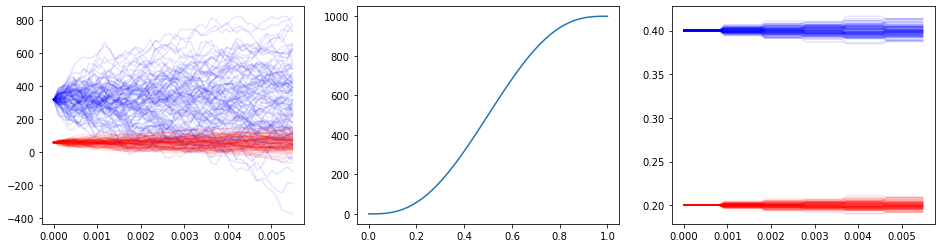

In [214]:
plt.figure(figsize = (16,4))
plt.subplot(1,3,1)
for i in range(100):
    plt.plot(timegrid, fwd_prices[:,i,-2], '-b', alpha=0.1)
    plt.plot(timegrid, fwd_prices[:,i,0], '-r', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)
plt.subplot(1,3,2)
x = np.linspace(0.0,1.0,50)
plt.plot(x,rdm.supply_curve.compute(x, 1000))

plt.subplot(1,3,3)
for i in range(100):
    plt.plot(timegrid, fwd_residuals[:,i,-2], '-b', alpha=0.1)
    plt.plot(timegrid, fwd_residuals[:,i,0], '-r', alpha=0.1)

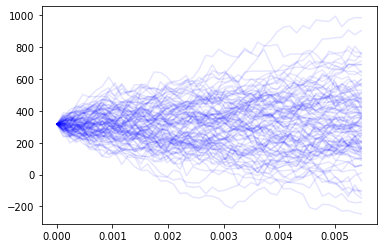

In [203]:
for i in range(100):
    plt.plot(timegrid, result[:,i,-2], '-b', alpha=0.1)
    #plt.plot(timegrid, result[:,i,2], '-r', alpha=0.1)

0.7938265290967064


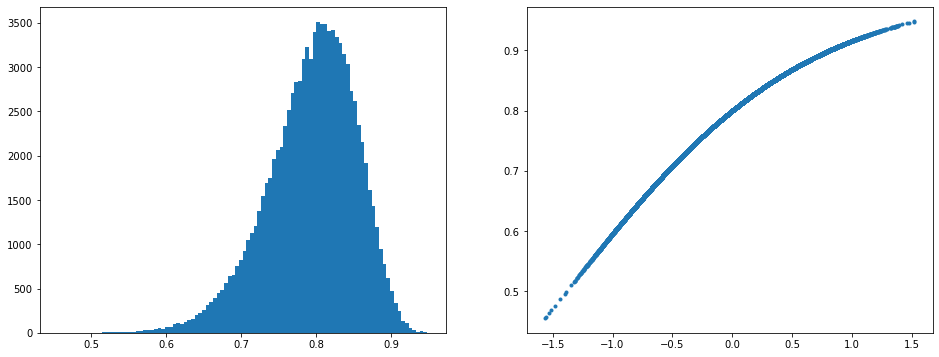

In [176]:
wind = WindPowerForecastModel(speed_of_mean_reversion=0.20, volatility=0.4, 
                             expiries=[1.0+i/(365.0*24.0) for i in range(24)],
                            forecasts = [0.8-i*0.4/23.0 for i in range(24)])

timegrid = np.linspace(0.0, 1.0, 100)
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = wind.simulate(timegrid, rnd)

expiry = 0
timepoint = 99
t = timegrid[timepoint]
fwd = wind.get_forward(paths[timepoint], t, expiry)
print(np.mean(fwd))
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.hist(fwd, bins = 100);
plt.subplot(1,2,2)
plt.plot(paths[timepoint], fwd,'.');

0.0009999999999999996
mean ou path  -6.906295444070689 inverse_logit of mean  0.001000458980437184  mean of inverse logit 0.0010680067285182893


-6.906754778648554

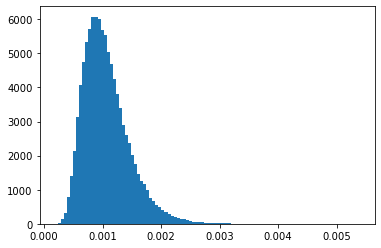

In [38]:

timepoint = -1
forecast = 0.001
ou = OrnsteinUhlenbeck(speed_of_mean_reversion=0.20, volatility=0.4, mean_reversion_level=0.0)
timegrid = np.linspace(0.0, 1.0, 100)
#scaling = 
correction = _logit(forecast)-ou.compute_expected_value(0.0, timegrid[timepoint])

print(_inv_logit(ou.compute_expected_value(0.0, timegrid[timepoint])+correction))
rnd = np.random.normal(size=(timegrid.shape[0], 100_000))
paths = ou.simulate(timegrid, 0.0, rnd) + correction
paths_inv_logit = _inv_logit(paths)

#plt.hist(paths[-1,:], bins=100)
plt.hist(paths_inv_logit[timepoint,:], bins=100);
print('mean ou path ', np.mean(paths[timepoint,:]), 'inverse_logit of mean ',_inv_logit(np.mean(paths[timepoint,:])), 
      ' mean of inverse logit',np.mean(paths_inv_logit[timepoint,:]))

_logit(forecast)